# Telecomunicaciones: identificar operadores ineficaces

### Descripción del proyecto

El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisoras información sobre los operadores menos eficaces. Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.


**Descripción de los datos**

Los datasets contienen información sobre el uso del servicio de telefonía virtual CallMeMaybe. Sus clientes son organizaciones que necesitan distribuir gran cantidad de llamadas entrantes entre varios operadores, o realizar llamadas salientes a través de sus operadores. Los operadores también pueden realizar llamadas internas para comunicarse entre ellos. Estas llamadas se realizan a través de la red de CallMeMaybe.

El dataset comprimido `telecom_dataset_us.csv` contiene las siguientes columnas:

- `user_id`: ID de la cuenta de cliente
- `date`: fecha en la que se recuperaron las estadísticas
- `direction`: "dirección" de llamada (`out` para saliente, `in` para entrante)
- `internal`: si la llamada fue interna (entre los operadores de un cliente o clienta)
- `operator_id`: identificador del operador
- `is_missed_call`: si fue una llamada perdida
- `calls_count`: número de llamadas
- `call_duration`: duración de la llamada (sin incluir el tiempo de espera)
- `total_call_duration`: duración de la llamada (incluido el tiempo de espera)

 

El conjunto de datos `telecom_clients_us.csv` tiene las siguientes columnas:

- `user_id`: ID de usuario/a
- `tariff_plan`: tarifa actual de la clientela
- `date_start`: fecha de registro de la clientela


### objetivos

- Identificar operadores ineficaces
- Prueba las hipótesis estadísticas


### Instrucciones para completar la tarea


**Paso 1.** Subir los archivos base de datos.

**Paso 2.** Abrir los archivos de datos y leer la información general.

**Paso 3.** Preparar los datos para el análisis de datos 

  - Convertir los tipos de los datos si es necesario;
  - Comprobar si hay valores ausentes o duplicados, si hay decidir cómo tratarlos;
  - Corregir los datos si es necesario.
  
**Paso 4.** Llevar a cabo el análisis de los datos.

- Muestra el número de llamadas entrantes perdidas (descendente)
    - Filtrar las llamadas entrantes perdidas;
    - Calcular el número total de llamadas salientes perdidas por cada operador y unir con 'groupby' por operador y las llamadas perdidas (ordena de mayor a menor);
    - Visualiza ¿qué operadores son los que tienen mayor número de llamadas (entrantes) perdidas?
- Muestra el mayor tiempo de espera promedio para las llamadas entrantes de cada operador
    - Crea una cloumna nueva llamada 'call_waiting' que calcule el tiempo de espera de cada llamada;
    - Obtener el tiempo de espera promedio por operador y calcular el promedio de espera, uniendolo por 'groupby' (ordena de mayor a menor);
    - ¿Quienes son los operadores que hacen un tiempo de espera prolongado?

- Identifica los operadores con actividad baja en llamadas salientes
    - Filtrar las llamadas salientes, selecciona solo las filas 'out';
    - Agrupar el número total de llamadas salientes por el operador (ordena de mayor a menor);
    - Calcular la mediana de llamadas salientes y identificar los operadores por debajo de esta que hacen menos llamadas salientes de lo esperado.

-  Identifica los operadores que tienen bajo rendimiento en más de 1 críterio y se concidere ineficaz
    - ¿Cuántos operadores existen con 1 actividad baja, cuántos con 2 y cuántos con 3? Saca conclusiones;
    - ¿Hay varios operadores repetidos en los tops de las tablas son diferentes?,¿Dónde hay mayor deficiencia por parte de los operadores?, ¿Hay algo que te llame la atención?.

**Paso 5.** Hipótesis
- En base al análisis de datos hay alguna hipótesis de la que se pueda sacar conclusiones.
  - ¿Hay algunas variables relevantes que se puedan análizar entre si?;
  - Define qué diferencia se quiere medir.
- Plantea la pregunta de investigación.
  - Fórmula la hipótesis nula y alternativa;
  - Selecciona la prueba estadística adecuada
- Ejecuta la prueba y saca conclusiones

## Inicializacion de los datos

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

In [51]:
telecom = pd.read_csv('/datasets/telecom_dataset_us.csv')
clients = pd.read_csv('/datasets/telecom_clients_us.csv')

### Explorar datos

In [52]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [53]:
telecom.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


La tabla `telecom` contiene 9 columnas con 53 902 entardas, las columnas en su mayoria estan sin valores nulos a excepcion de la columna `operator_id` que tiene solo 45 730 entaradas,también es importante resaltar que hay columnas que no tienen el tipo correcto como lo son date que debería ser un datetime, internal que preferiblemente debería ser un boleano y operator_id que aunque no es necesarío convertilo a int es la mejor opción. También es necesario verificar si contiene valores duplicados.

In [54]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


In [55]:
 clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


La tabla `clients` contiene 3 columnas con 732 filas y no se obserban valores nulos, aunque en la columna date_start es de tipo equivocado y deberá ser cambiado a datetime. También es necesario revisar si contiene valores duplicados.

##  Corrección de datos: tipos, ausentes y duplicados

### Tabla `telecom`

In [56]:
# Cambio de tipo de object a datetime
telecom['date'] = pd.to_datetime(telecom['date'])

# Cambio de tipo de object a bool
telecom['internal'] = telecom['internal'].astype(bool)

# Cambio de tipo de float a Int64
telecom['operator_id'] = telecom['operator_id'].astype('Int64')

print('Verificación de cambio object a datetime:', telecom['date'].dtype)
print('\nVerificación de cambio object a bool:', telecom['internal'].dtype)
print('\nVerificación de cambio float a Int64:', telecom['operator_id'].dtype)

Verificación de cambio object a datetime: datetime64[ns, pytz.FixedOffset(180)]

Verificación de cambio object a bool: bool

Verificación de cambio float a Int64: Int64


Se puede observar que hay 8172 valores ausentes en la columna de 'operator_id' que esta destinada a almacenar el Id único de cada operador que hace llamadas. En esta ocación dado que posiblemente hubo alguna falla que no almacenó los datos, no se sabe si solo es un id de un operador que no se almacena o si son varios id de operadores que no se han almacenado por eso he decidido dejarlo así por el momento pero más adelante en el análisis crear una copia de `telecom` excluyendo estos datos para que no alteren los resultados del análisis.

In [57]:
# Visulización de valores ausentes
telecom.isna().sum()

user_id                   0
date                      0
direction                 0
internal                  0
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

La tabla `telecom` contiene 4 900 filas duplicadas así que deben ser eliminadas quedando en total 49 002 filas en el DataFrame.

In [58]:
# Visualización de valores duplicados
telecom.duplicated().sum()

4900

In [59]:
telecom.drop_duplicates()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,<NA>,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,25
...,...,...,...,...,...,...,...,...,...
53896,168606,2019-11-10 00:00:00+03:00,out,True,957922,False,1,0,25
53897,168606,2019-11-10 00:00:00+03:00,out,True,957922,True,1,0,38
53898,168606,2019-11-11 00:00:00+03:00,out,True,957922,False,2,479,501
53899,168606,2019-11-15 00:00:00+03:00,out,True,957922,False,4,3130,3190


In [60]:
telecom = telecom.drop_duplicates()

### Tabla `clients`

In [61]:
# Cambio de tipo de object a datetime
clients['date_start'] = pd.to_datetime(clients['date_start'])

print('Verificación de cambio object a datetime:', clients['date_start'].dtype)

Verificación de cambio object a datetime: datetime64[ns]


In [62]:
# Visulización de valores ausentes
clients.isna().sum()

user_id        0
tariff_plan    0
date_start     0
dtype: int64

In [63]:
# Visualización de valores duplicados
clients.duplicated().sum()

0

## Análisis de datos

Esta variable contiene una copia del DateFrame `telecom` sin datos nulos para tener un análisis más limpio y conserbar intacto el original.

In [64]:
# Nuevo telecom sin datos nulos
telecom_free_null = telecom.dropna(subset = ['operator_id']).copy()

In [65]:
# Numero de operadores
telecom_free_null['operator_id'].nunique()

1092

### Muestra el número de llamadas entrantes perdidas (descendente)

Los datos de la tabla muestran a los operadores que tinen mayor número de llamadas perdidas como el operador con el Id 913942 encabeza la lista con 52 llamadas perdidas después hay un gran desceso de 22 llamadas perdidas con los operadores 944226 y 885890 que ambos tienen 30, en cuarto lugar lo ocupa el operador 885890 con 26 seguidos de los operadores 944216 y 937956 con 24. Como se muestra la perdida de llamadas va disminuyendo en gran medida del primer lugar al segundo y después de esto la disminución no es tan drastica pero es constante, este evento puede llegar a afectar a la empresa porque puede generar quejas y mal humor por parte de los clientes lo que podría dar mala imagen a la empresa e incluso si es constante los clientes podrían cambiar de compañia.

In [66]:
# Filtro de llamadas entrantes perdidas
in_misscall = telecom_free_null[(telecom_free_null['is_missed_call'] == True) & (telecom_free_null['direction'] == 'in')]

# Tabla con filtro de llamadas entrantes perdidas por operador y número de llamadas
total_misscalls = in_misscall.groupby('operator_id')['calls_count'].sum().reset_index()
total_misscall = total_misscalls.sort_values(by = 'calls_count', ascending = False)


display(total_misscall.head(10))
total_misscall.shape

,operator_id,calls_count
98,913942,52
196,940588,30
210,944226,30
6,885890,26
206,944216,24
179,937956,24
222,951508,21
5,885876,20
208,944220,18
209,944222,17


(239, 2)

El diagrama nos muestra que hay muchos operadores con más de 10 llamadas perdidas siendo esto valores atipicos dentro del rango de los operadores. A simple vista se podría decir que las llamadas perdidas que tiene la mayoria de los operadores es de 3. Para confirmar esto es necesario sacar los percentiles que nos pueden confirmar cúal es la cantidad ideal de llamadas perdidas.

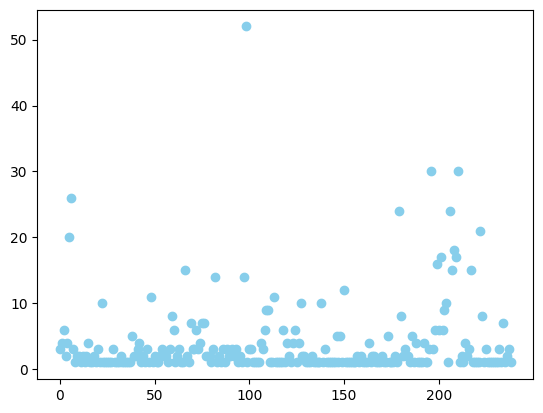

In [108]:
# Rango de números desde 0 hasta el número de observaciones en total_misscalls
x_values = pd.Series(range(0,len(total_misscalls)))

# Diagrama
plt.scatter(x_values, total_misscalls['calls_count'], color = 'skyblue')

Para observar el umbral claramente en este caso se calculará con percentiles de 75, 90 y 95. El primero nos ayudará a identificar operadores que están por encima del desempeño promedio aceptable, el percentil 90 a operadores en casos peores a el anterior y en el caso de los percentil 95 son casos extremos.

En este caso el percentil 75 nos muestra el umbral de un desempeño aceptable es de 4 llamadas perdidas, casos aceptables pero por fuera de lo ideal es de 9 llamadas perdidas y el percentil 95 nos muestra que el 5% de los operadores tienen más de 15 llamadas perdidas saliendo por mucho de lo ideal. La gráfica nos da una representación de una imagen clara de estos datos.

In [68]:
percentil_75_misscall = np.percentile(total_misscall['calls_count'], 75)
percentil_90_misscall = np.percentile(total_misscall['calls_count'], 90)
percentil_95_misscall = np.percentile(total_misscall['calls_count'], 95)

print(percentil_75_misscall)
print(percentil_90_misscall)
print(percentil_95_misscall)

4.0
9.200000000000017
15.099999999999994


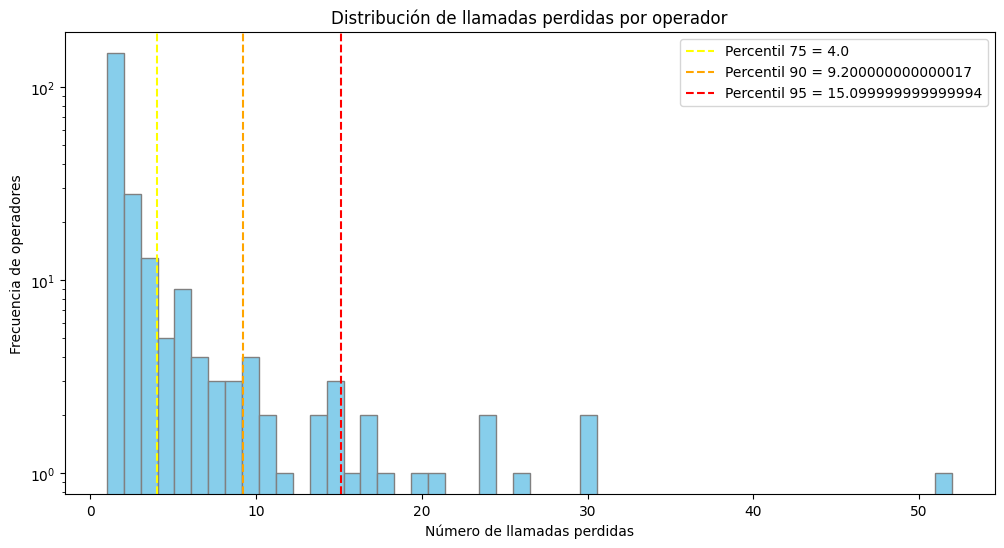

In [123]:
plt.figure(figsize=(12, 6))
plt.hist(total_misscall['calls_count'], bins = 50, color = 'skyblue', edgecolor = 'grey', log = True)
plt.axvline(percentil_75_misscall, color = 'yellow', linestyle = 'dashed', linewidth = 1.5, label = f'Percentil 75 = {percentil_75_misscall}')
plt.axvline(percentil_90_misscall, color = 'orange', linestyle = 'dashed', linewidth = 1.5, label = f'Percentil 90 = {percentil_90_misscall}')
plt.axvline(percentil_95_misscall, color = 'red', linestyle = 'dashed', linewidth = 1.5, label = f'Percentil 95 = {percentil_95_misscall}')

plt.title('Distribución de llamadas perdidas por operador')
plt.xlabel('Número de llamadas perdidas')
plt.ylabel('Frecuencia de operadores')
plt.legend()

### Muestra el mayor tiempo de espera promedio para las llamadas entrantes de cada operador

Para saber el tiempo de espera primero es necesario restar las columnas 'total_call_duration' (tiempo total de la llamada) y la columna 'call_duration' (duración de llamada sin tiempo de espera) que se almacenará en una nueva columna llamada 'wait_duration', después es necesario crear un filtro solo para las llamadas entrantes y así calcular el tiempo promedio de espera que hizo cada operador viendola de forma descendiente para identificar quienes hacen mayor tiempo de espera y cuanto es.

In [70]:
# Creación de la columna 'wait_duration' que almacena solo la duración de llamadas en espera
telecom_free_null['wait_duration'] = telecom_free_null['total_call_duration'] - telecom_free_null['call_duration']

# Verificación de la columna agregada
display(telecom_free_null.head())

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,wait_duration
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18,8
4,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,25,25
5,166377,2019-08-05 00:00:00+03:00,out,False,880020,False,2,3,29,26


__¿Quienes son los operadores que hacen un tiempo de espera prolongado para llamadas entrantes?__

Se puede obserbar la gran diferencia el mayor tiempo de espera promedio que se tiene es de 1007.37 segundos (17 minutos aprox) hecho por el operador Id 919794, después hay un desceso de tiempo hasta 889.80 segundos por  el operador 906070 y 866.80 del operador 919790 (14 minutos aprox en ambos), y aunque se puede ver que el tiempo de espera esta bajando rápidamente aún así es excesivamente prolongado para lo que se espera, esto nos puede dar a entender que puede haber un problema en la distribución de llamadas, desempeño individual de estos operadores o insuficiencia de personal.

In [71]:
# Filtro de llamadas entrantes
in_call = telecom_free_null[telecom_free_null['direction'] == 'in']

# Tabla con filtro 'in' que muestra el promedio de tiempo de espera que hace cada operador
wait_call_per_operator =  in_call.groupby('operator_id')['wait_duration'].mean().reset_index()
wait_call_per_operators = wait_call_per_operator.sort_values(by = 'wait_duration', ascending=False)

display(wait_call_per_operators.head(10))
wait_call_per_operator.shape

,operator_id,wait_duration
337,919794,1007.375000
206,906070,889.800000
335,919790,866.803279
445,931458,681.961538
358,921318,615.418182
207,906076,611.500000
333,919552,561.757576
328,919204,550.941176
288,913938,526.974026
334,919554,503.157895


(754, 2)

El diagrama nos muestra que existen muchos operadores que pueden sobrepasar el rango de los operadores que se consideran eficaces, estos pueden llegara tener mas de 190 segundos por encima (siendo este un rango dado a simple vista). Para confirmar esto es necesario sacar los percentiles que nos pueden confirmar cúal es la cantidad ideal de llamadas perdidas.

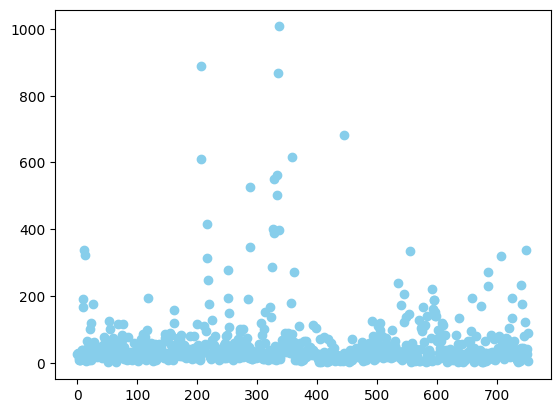

In [109]:
# Rango de números desde 0 hasta el número de observaciones en wait_call_per_operator
x_values = pd.Series(range(0,len(wait_call_per_operator)))

# Diagrama
plt.scatter(x_values, wait_call_per_operator['wait_duration'], color = 'skyblue')

Para observar el umbral claramente en este caso se calculará con percentiles de 75, 90 y 95. El primero nos ayudará a identificar operadores que están por encima del desempeño promedio aceptable, el percentil 90 a operadores en casos peores a el anterior y en el caso de los percentil 95 son casos extremos.

En este caso el percentil 75 nos muestra el umbral de un desempeño aceptable es de 58 segundos de espera en promedio, fuera de lo ideal siendo el 10% son 114.05 segundos (1 minuto aprox) y el percentil 95 nos muestra los operadores que se salen por mucho de lo ideal a partir de 187.41 segundos (3 minutos aprox) en adelante. La gráfica nos da una representación de una imagen clara de estos datos se identifica con la linea amarilla el percentil 75 que muestra el limite de la eficacia entre operadores, el naranja que muestra los operadores que estan en el 'limbo' de ser ineficaces o eficaes y la linea roja que representa el percentil 95 nos muestra casos críticos entre los operadores.

In [74]:
percentil_75_wait = np.percentile(wait_call_per_operator['wait_duration'], 75)
percentil_90_wait = np.percentile(wait_call_per_operator['wait_duration'], 90)
percentil_95_wait = np.percentile(wait_call_per_operator['wait_duration'], 95)

print(percentil_75_wait)
print(percentil_90_wait)
print(percentil_95_wait)

58.0
114.05000000000007
187.41348039215686


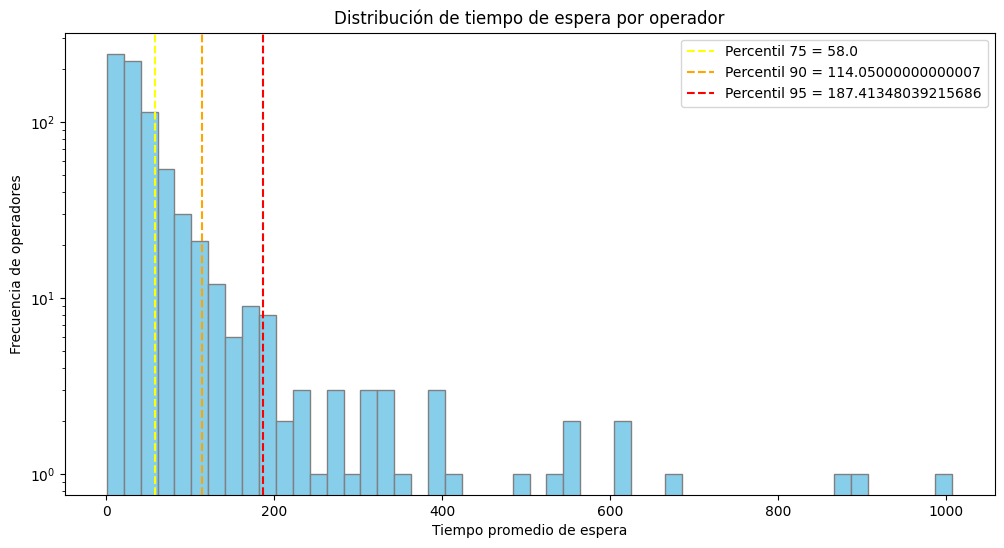

In [124]:
plt.figure(figsize=(12, 6))
plt.hist(wait_call_per_operator['wait_duration'], bins = 50, color = 'skyblue', edgecolor = 'grey', log = True)
plt.axvline(percentil_75_wait, color = 'yellow', linestyle = 'dashed', linewidth = 1.5, label = f'Percentil 75 = {percentil_75_wait}')
plt.axvline(percentil_90_wait, color = 'orange', linestyle = 'dashed', linewidth = 1.5, label = f'Percentil 90 = {percentil_90_wait}')
plt.axvline(percentil_95_wait, color = 'red', linestyle = 'dashed', linewidth = 1.5, label = f'Percentil 95 = {percentil_95_wait}')

plt.title('Distribución de tiempo de espera por operador')
plt.xlabel('Tiempo promedio de espera')
plt.ylabel('Frecuencia de operadores')
plt.legend()

### Identifica los operadores con actividad baja en llamadas salientes

Para identificar los operadores que tienen poca actividad al hacer llamadas salientes se deben filtrar las llamadas salientes para después sumar todas por operador, esto nos dará cuantas llamadas ha hache cada operador. Después para tener idea del rango de llamadas que debería tener los operadores es necsesario observar cuáles son los valores atípicos mediante un diagrama y los percentiles. 

Hay muchos operadores con bajo rendimiento y en este caso el id del operador que encabeza la lista con tan solo 1 llamada es 955086 pero no podría ser señalado como el peor ya que muchos comparten su desempeño así que sera mejor visualizar cuantos operadores tienen ese desempeño y compararlos con los demás que tambien estan por debajo de lo recomendable.

In [121]:
# Filtro para llamadas salientes
out_calls = telecom_free_null[telecom_free_null['direction'] == 'out']

# Tabla con filtro 'out' que muestra la suma de 'calls_counts'
out_call_per_operators = out_calls.groupby('operator_id')['calls_count'].sum().reset_index()
out_call_per_operator = out_call_per_operators.sort_values(by = 'calls_count', ascending = True)

# Verificación 
display(out_call_per_operator.head(10))
out_call_per_operator.shape

,operator_id,calls_count
793,955086,1
841,963716,1
293,914272,1
495,932246,1
168,902238,1
653,941816,1
853,966686,1
654,941826,1
102,895266,1
545,937720,1


(882, 2)

El diagrama nos muestra en este caso que no hay muchos valores atípicos que pueden llegar hasta 60 000 de llamadas salientes acumuladas, en este caso como lo ideal es que se hagan el mayor número de llamadas los valores atípicos serían los que esten más apegados a la linea x. Se puede obserbar que hay gran acumulación de operadores que no hacen el promedio de llamadas salientes correspondientes.

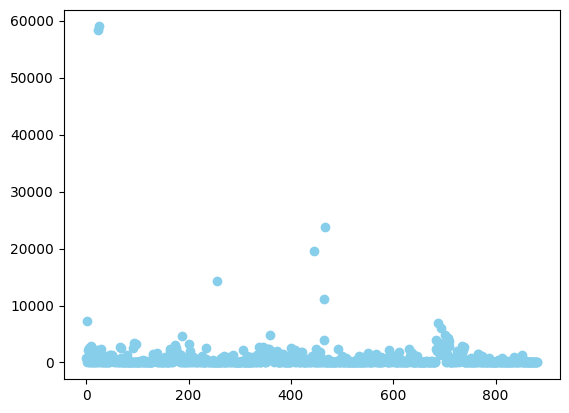

In [110]:
# Rango de números desde 0 hasta el número de observaciones en out_call_per_operators
x_values = pd.Series(range(0,len(out_call_per_operators)))

# Diagrama
plt.scatter(x_values, out_call_per_operators['calls_count'], color = 'skyblue')

Los percentiles muestran que el 5% de los operadores rondan entre las 2 362 o más llamadas salientes hechas,mucho más de lo pedido. El percentil 90 nos muestra que el 10% hace 1 602 llamadas salientes, y el percentil 75 que es lo minímo ideal de llamadas que se deberían hacer es de 597. Esto nos da a entender que los números son muy bajos por parte de los operadores que no llenan el requicito minímo.

In [94]:
percentil_75_callout = np.percentile(out_call_per_operators['calls_count'], 75)
percentil_90_callout = np.percentile(out_call_per_operators['calls_count'], 90)
percentil_95_callout = np.percentile(out_call_per_operators['calls_count'], 95)

print(percentil_75_callout)
print(percentil_90_callout)
print(percentil_95_callout)

597.25
1602.9
2362.95


En este caso los operadores con bajo rendimiento de llamadas salientes es más de la mitad de estos a diferencia de lo que hemos visto a lo largo del análisis, esto es alarmante ya que puede ocasionar perdida de ingresos adicionales, aumento de cancelación por parte de los clientes e incluso se puede perder información valiosa para mejorar los servicios.

Se observa que en la gráfica hay más de 60 operadores que solo han hecho 1 llamada, esto baja en gran medida con alrededor de 28 operadores que hicieron 2 llamadas y 25 con 3 llamadas salientes. A lo largo del gráfico se muestra que después de los operadores que hicieron de 1 a 3 llamadas hay una baja de operadores que no tuvo buen rendimiento en hacer las llamadas aún hay muchos picos alrededor de 10 000 y 60 000 operadores teniendo bajo rendimiento este comportamiento pueder ser causado por falta de capacitación, problemas técnicos o de distribución adecuada, desmotivación o deficiencias en la supervisión.

No handles with labels found to put in legend.


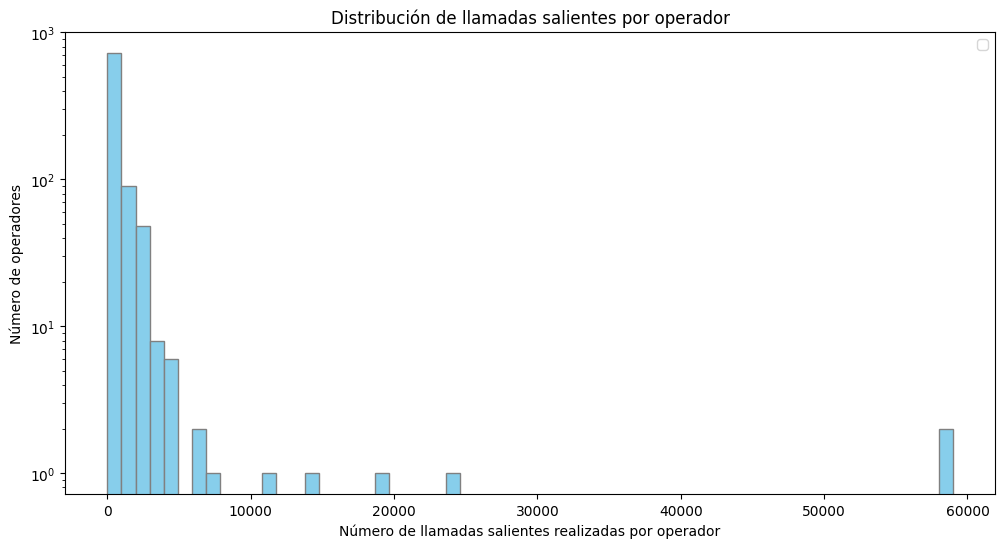

In [118]:
plt.figure(figsize=(12, 6))
plt.hist(out_call_per_operators['calls_count'], bins = 60, color = 'skyblue', edgecolor = 'grey', log = True)
plt.title('Distribución de llamadas salientes por operador')
plt.xlabel('Número de llamadas salientes realizadas por operador')
plt.ylabel('Número de operadores')
plt.legend()

 ###  Identifica los operadores que tienen bajo rendimiento en más de 1 críterio y se concidere ineficaz

Para identificar los operadores que tienen más de un críterio con bajo rendimiento primero hay que unir mediante merge las tablas hechas anteriormente que son `total_misscall` que almacena los operadores y su total de llamadas entrantes perdidas, `wait_call_per_operator` almacena los operadores  y su tiempo promedio de espera en las llamadas, por último la tabla `out_call_per_operator` que almacena las llamadas salientes que hace cada operador. Teniendo la tabla `ineff_operators`, que es la union de las tablas antes mencionadas, es necesario obtener los valores límite que en este caso se usarán los percentiles 75 que nos da a los operadores que están por encima del desempeño promedio aceptable de cada críterio columna para después crear la columna `ineffective` que mediante una métrica filtre los valores límite y de como resultado con cuántos críterios tiene cada operador.

In [103]:
# Union mediante merge de la tabla 'ineff_operators'
ineff_operators = total_misscall.merge(wait_call_per_operator, on = 'operator_id', how = 'outer')
ineff_operators = ineff_operators.merge(out_call_per_operator, on = 'operator_id', how = 'outer')

# Cambio de nombre de las columnas calls_count
ineff_operators = ineff_operators.rename(columns={'calls_count_x': 'miss_calls', 'calls_count_y': 'insuff_calls'})

display(ineff_operators.head())

,operator_id,miss_calls,wait_duration,insuff_calls
0,913942,52.0,347.917647,440.0
1,940588,30.0,127.230769,67.0
2,944226,30.0,153.580000,109.0
3,885890,26.0,120.276596,58977.0
4,944216,24.0,160.923077,133.0


In [104]:
#  Creación de la columna 'ineffective' según ineficiencia de los valores límite
ineff_operators['ineffective'] = (
    (ineff_operators['miss_calls'] > percentil_75_misscall).astype(int) +
    (ineff_operators['wait_duration'] > percentil_75_wait).astype(int) +
    (ineff_operators['insuff_calls'] < percentil_75_callout).astype(int)
)

Son 126 operadores que tienen 2 o más críterios de ineficacia acumulados, esta tabla nos da el Id de los operadores que no cumplen eficientemente con el rendimiento esperado dentro de la empresa, también muestra los críterios individuales como son las llamadas perdidas, el tiempo de espera y las llamadas salientes que se hicieron. Ve mos al operador 906410 ocupando el primer lugar en ineficacia, seguido del los operadores 919206 y 945046 aunque estos lugares pueden ser relativos dependiendo el enfoque que se dé por ejemplo aunque esta en primer lugar tiene menos llamadas perdidas que el segundo lugar al igula que menos tiempo de espera.

In [105]:
# Filtro que identifica los operadores con 2 o más críterios acumulados 
ineffective_ops = ineff_operators[ineff_operators['ineffective'] >= 2]

display(ineffective_ops.sort_values(by = 'ineffective', ascending = False).head(10))
ineffective_ops.shape

,operator_id,miss_calls,wait_duration,insuff_calls,ineffective
0,913942,52.0,347.917647,440.0,3
38,919166,6.0,401.714286,20.0,3
26,919206,9.0,388.052632,1.0,3
25,919204,9.0,550.941176,9.0,3
31,906410,7.0,177.500000,19.0,3
18,919554,11.0,503.157895,11.0,3
1,940588,30.0,127.230769,67.0,3
16,913938,14.0,526.974026,408.0,3
15,908960,14.0,150.592593,113.0,3
13,944218,15.0,187.416667,164.0,3


(126, 5)

La distribución de puntuación nos muestra que son más los operadores que cuentan con gran eficiencia contando con nulos malos críterios o solamente 1 esto son buenas noticias para la empresa. Por otra parte podemos obserbar que los que cuentan con 2 críterios acumulados son 108 operadores y con 3 son solamente 18.

In [106]:
# Variable que muestra la distribución de puntuación de ineficacia de los operadores
distribution_ineff = ineff_operators['ineffective'].value_counts().sort_index()

display(distribution_ineff)

0    339
1    627
2    108
3     18
Name: ineffective, dtype: int64

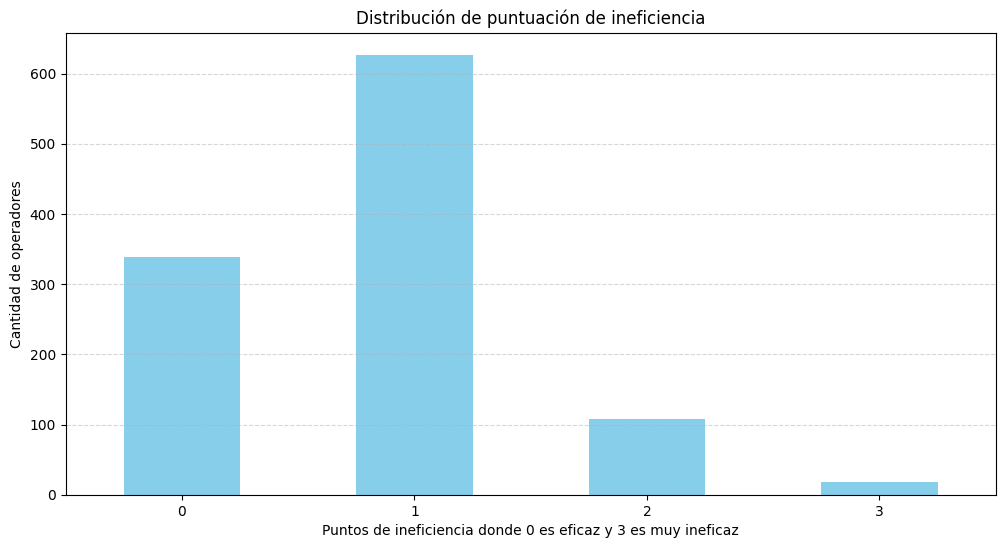

In [122]:
# Gráfica para visualizar la distribución de puntuación de ineficiencia entre los operadores
distribution_ineff.plot(kind = 'bar', color = 'skyblue', figsize = (12, 6))
plt.title('Distribución de puntuación de ineficiencia')
plt.xlabel('Puntos de ineficiencia donde 0 es eficaz y 3 es muy ineficaz')
plt.ylabel('Cantidad de operadores')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.xticks(rotation = 0)
plt.show()

## Hipótesis

La hipótesis planteada a continuación surgió al visualizar la gráfica y datos de llamadas perdidas entrantes, ya que como mencioné antes que es cierto que hay algunos operadores con una cantidad considerable de llamadas perdidas también creo que los números bajan considerablemente y se mantienen constantes, por eso decidí verificar si hay una diferencia significativa en la cantidad de llamadas perdidas entre operadores ineficaces y eficaces mediante la prueba no paramétrica de Wilcoxon-Mann-Whitney.

__Hipótesis nula:__ No hay diferencia significativa en la cantidad de llamadas perdidas entre operadores ineficaces y eficaces.

__Hipótesis alternativa:__ Los operadores ineficaces tienen una cantidad significativamente mayor de llamadas perdidas en comparación con los eficaces.

In [88]:
operador_eficaz = total_misscall[total_misscall['calls_count'] <= percentil_75_misscall]['calls_count']
operador_ineficaz = total_misscall[total_misscall['calls_count'] > percentil_75_misscall]['calls_count']

alpha = 0.05

stat, p_valor = stats.mannwhitneyu(operador_eficaz, operador_ineficaz, alternative='less')

print('Estadístico de prueba:', stat)
print('Valor p:', p_valor)


if p_valor < alpha:
    print('Rechazamos la hipótesis nula: Los operadores ineficaces tienen una cantidad significativamente mayor de llamadas perdidas en comparación con los eficaces.')
else:
    print('No podemos rechazar la hipótesis nula: No hay diferencia significativa en la cantidad de llamadas perdidas entre operadores ineficaces y eficaces.')

Estadístico de prueba: 0.0
Valor p: 5.972612138859504e-30
Rechazamos la hipótesis nula: Los operadores ineficaces tienen una cantidad significativamente mayor de llamadas perdidas en comparación con los eficaces.


Como podemos ver la hipótesis nula fue rechazada lo que indica que los operadores ineficaces tienen una cantidad significativamente mayor de llamadas perdidas en comparación con los eficaces lo que claramnete puede considerarse un problema porque puede causar perdida de clientela, mala fama o marketing, quejas contantes, etc. Aunque por otro lado más positivo también se abre la puerta a nuevas estrategias que cambien el panorama y erradiquen el problema.

## Conclusión

A lo largo del análisis podemos observar que hay operadores que tienen bajo rendimiento en algunas areas teniendo en cuenta que  ningún Id de estos se repite visiblemente en las tablas que se muestran los 10 operadores más ineficaces, lo que da a entender que aunque estén o no en la lista de operadores ineficaces no hay Ids concentrados en los peores lugares. Recordando que los operadores considerados ineficaces tienen 2 a 3 criterios malos acumulados es visible que es una cantidad mínima a comparación de los operadores eficaces.

Estas podrían ser algunas soluciones a problemas que podrían estar causando la ineficiencia por parte de los operadores:
  
  - Para las llamadas perdidas entrantes: Algunas veces en las horas pico no hay suficiente personal disponible lo que causa aumento de llamadas perdidas en estos casos incrementar el número de operadores en horarios con mayor actividad puede ayudar a disminuir esto. 
  - Para el tiempo de espera prolongado: esto podría deberse a la falta de capacitación de los operadores por eso recomiendo altamente hacer capacitaciones recurrentes, así también como tener un reglamento claro al que puedan recurrir o también que tengan visualmente su rendimiendo por medio de un dashboard.
  - Para la falta de llamadas salientes: puede deberse a la falta de motivación por parte de los empleados por eso recomiendo en estos casos dar incentivos esto ayudará a mejorar la motivación y eficiencia de los operadores, estos se pueden dar después de lograr cierto número de llamadas o por período de tiempo manteniendo un alto rendimiento.
  
   
También para ayudar a solucionar estas tres problematicas se podría recurrir a empresas que se dedican a la mejora de la gestión de las operaciones de servicio dando capacitación a empleados o implementando estrategias según las necesidades de la empresa. A tomar en cuenta 'actdigital'.